<a href="https://colab.research.google.com/github/ibonetc/IA_2024/blob/main/Heur%C3%ADstica_AlgoritmosB%C3%BAsqueda/IA_EIA_LatLong_InformacionMapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Localización en mapas

Captura de información para poder hacer métodos de rutas

Se debe instalar el paquete osmnx, que permite obtener mapas en un grafo con información de latitud y longitud de diferentes puntos, con sus distancias

**Nota** : Después de instalar la biblioteca osmnx debe reiniciar el entorno de ejecuación y entonces ejecutar el siguiente código

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt
import plotly_express as px

import networkx as nx
import osmnx as ox
#ox.config(use_cache=True, log_console=True)

## Mapa de Envigado

La función **graph_from_place** recibe un texto con la dirección del lugar que se desea buscar, y tiene un parámetro *network_type* para ver cómo se desea obtener el mapa, en nuestro caso que queremos hacer ruts para trayecto en carro escogeremos: 'drive'

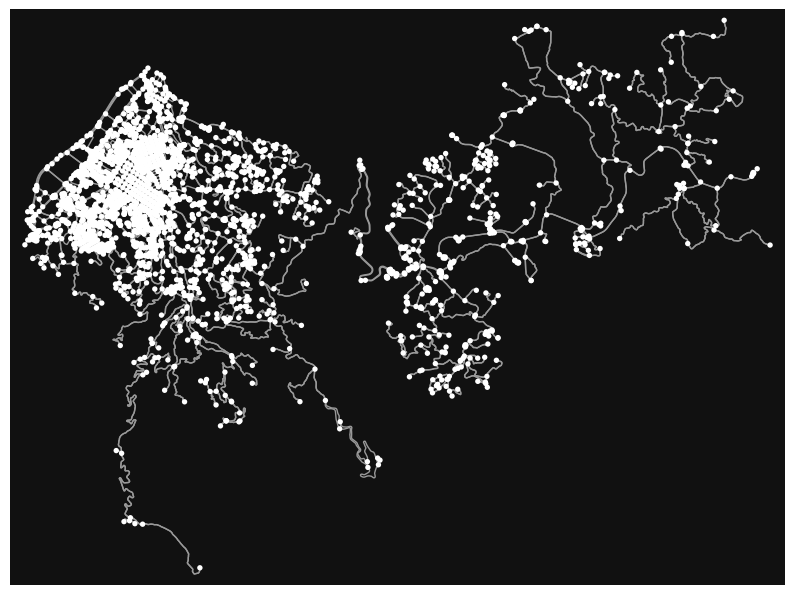

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [2]:
G = ox.graph_from_place('Envigado, Antioquia, Colombia', network_type='drive')
ox.plot_graph(G,figsize=(10,10))

La función por defecto tiene un parámetro *simplify* puesto en True, por lo que trae un grafo simplificado, con pocos puntos. Como queremos tratar de mostrar el trayecto completo de la ruta vamos a traer más información del mapa y pondremos el parámetro en False.

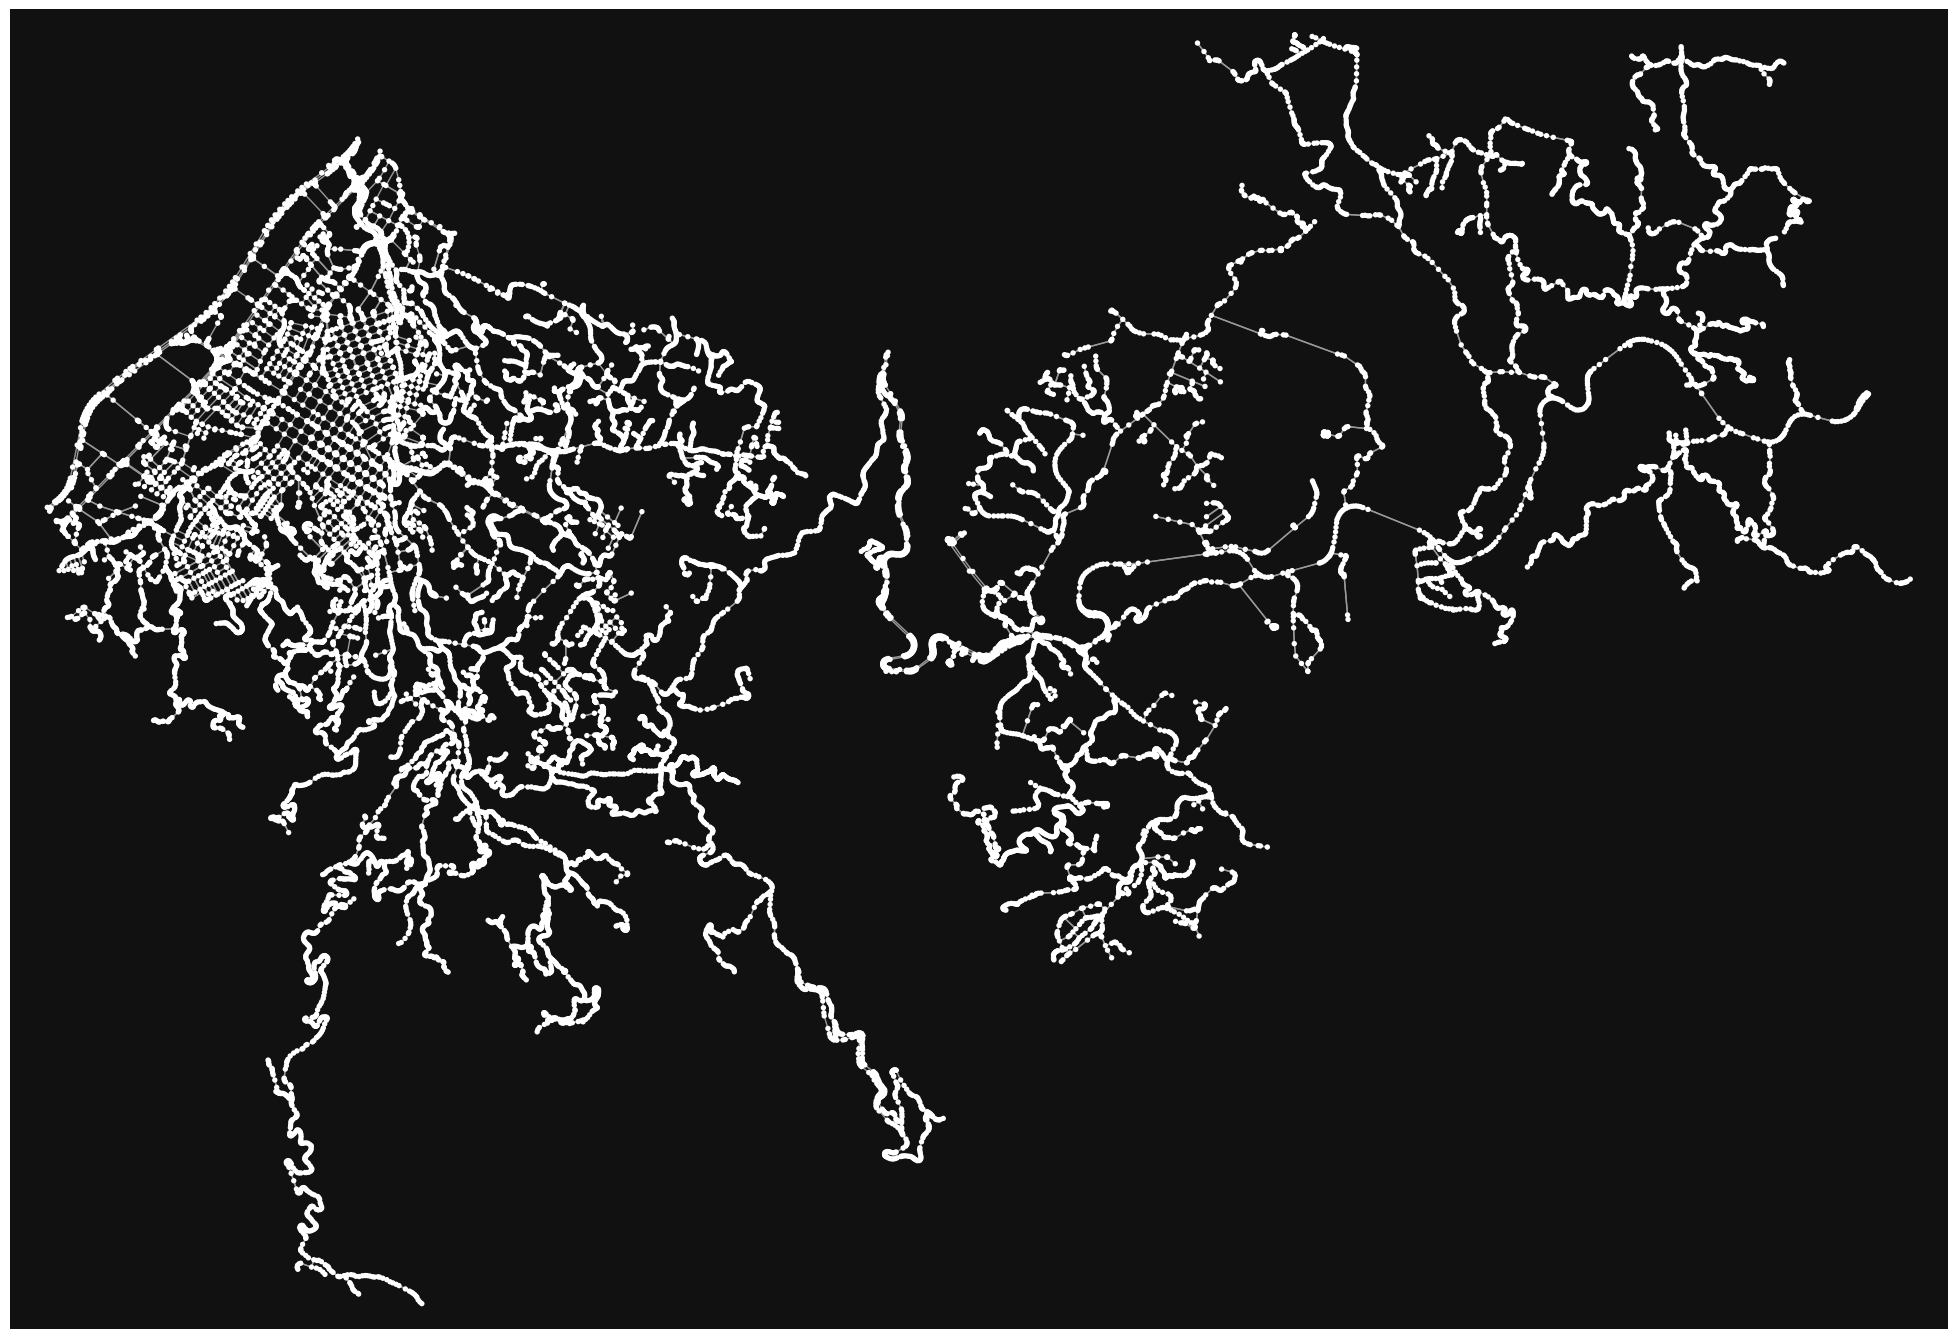

(<Figure size 2500x2500 with 1 Axes>, <Axes: >)

In [3]:
G = ox.graph_from_place('Envigado, Antioquia, Colombia', network_type='drive',simplify=False)
ox.plot_graph(G,figsize=(25,25))

La función *graph_to_gdfs(G)* nos devuelve dos dataframe uno con los nodos y otro con las aristas del grafo.

In [4]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [5]:
gdf_nodes.head()

y          x  street_count highway  \
osmid                                                  
309313450  6.158425 -75.519823             2     NaN   
309313451  6.158399 -75.520285             2     NaN   
309313454  6.159630 -75.521495             2     NaN   
309313455  6.160208 -75.522473             2     NaN   
309313457  6.159980 -75.524411             3     NaN   

                            geometry  
osmid                                 
309313450  POINT (-75.51982 6.15843)  
309313451  POINT (-75.52028 6.15840)  
309313454  POINT (-75.52150 6.15963)  
309313455  POINT (-75.52247 6.16021)  
309313457  POINT (-75.52441 6.15998)

In [6]:
gdf_edges.head()

osmid lanes                 name    highway  \
u         v          key                                                     
309313450 414940715  0    1019189334     2  Variante Las Palmas  secondary   
          440765240  0    1019189334     2  Variante Las Palmas  secondary   
309313451 414940727  0    1019189334     2  Variante Las Palmas  secondary   
          414940715  0    1019189334     2  Variante Las Palmas  secondary   
309313454 4124260034 0    1019190824     2  Variante Las Palmas  secondary   

                         maxspeed  oneway  reversed  length  ref width  \
u         v          key                                                 
309313450 414940715  0         50   False     False  24.138  NaN   NaN   
          440765240  0         50   False      True  91.294  NaN   NaN   
309313451 414940727  0         50   False     False  26.538  NaN   NaN   
          414940715  0         50   False      True  27.314  NaN   NaN   
309313454 4124260034 0         60   False     False  25.382  NaN   NaN   

                         junction bridge access  \
u         v          key                          
309313450 414940715  0        NaN    NaN    NaN   
          440765240  0        NaN    NaN    NaN   
309313451 414940727  0        NaN    NaN    NaN   
          414940715  0        NaN    NaN    NaN   
309313454 4124260034 0        NaN    NaN    NaN   

                                                                   geometry  
u         v          key                                                     
309313450 414940715  0    LINESTRING (-75.51982 6.15843, -75.52004 6.15839)  
          440765240  0    LINESTRING (-75.51982 6.15843, -75.51903 6.15866)  
309313451 414940727  0    LINESTRING (-75.52028 6.15840, -75.52051 6.15847)  
          414940715  0    LINESTRING (-75.52028 6.15840, -75.52004 6.15839)  
309313454 4124260034 0    LINESTRING (-75.52150 6.15963, -75.52164 6.15981)

Si observamos una parte del dataframe de las aristas, podemos ver que tenemos toda la información donde *u* es el nodo de partida, *v* el nodo de destino en cada uno de las conecciones de los puntos, tenemos el nombre del lugar o calle (name), el tipo de carretera (highway), la máxima velocidad en ese lugar (maxspeed), pero esta variable tiene varios nulos, para poder calcular tiempo en recurrido necesitamos llenar estos campos vacíos.

Podemos crear una variable speed_kph que se completa con los valores maxspeed y rellena los vacíos, por defecto, la función add_edge_speeds(G) rellena los vacíos con el promedio de ese tipo de carretera, en el mapa, pero podemos también pasarle unos valores fijos, como se hizo anteriormente.

Adicionar una columna con velocidad (**speed_kph**), a partir de la maxspeed que hay

Adicionar otra columna con el tiempo de viaje (**travel_time**)

In [7]:
#G = ox.add_edge_speeds(G)
# Para que en vez del promedio del tipo de vía, ponga uno específico como esté null
envigado_elevation_map = "./utils/envigado.tif"
hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}

G = ox.elevation.add_node_elevations_raster(G, envigado_elevation_map, band=1) # esta función añade la elevación a los nodos
G = ox.add_edge_speeds(G,hwy_speeds)
G = ox.add_edge_travel_times(G)
G= ox.add_edge_grades(G, add_absolute=True)
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

La relación que hay entre gdf_nodes y gdf_edges es que  gfd_nodes tiene la información de los nodos y gdf_edges tiene la información de las aristas, por lo que en gdf_edges tenemos la información de los nodos de partida y destino, y en gdf_nodes tenemos la información de los nodos.
Una arista en este caso se refiere a una conexión entre dos nodos, por lo que en gdf_edges tenemos la información de las conexiones entre los nodos.

Esto es importante para poder calcular la distancia entre dos nodos, que se puede hacer con la función distance en la librería geopy, que recibe dos puntos y devuelve la distancia en metros.

Ahora bien, necesitamos calcular el angulo de inclinación de la carretera, para poder calcular el tiempo de viaje, para esto vamos a usar la función **add_edge_bearings(G)** que nos devuelve el ángulo de inclinación de la carretera en cada una de las aristas.

In [8]:
gdf_edges[150:160]

osmid lanes          name      highway  \
u         v           key                                                
330634666 1378816147  0     297281673   NaN    Carrera 39  residential   
          330634181   0     577258425     3  Calle 37 Sur    secondary   
330634667 8895905676  0     123728026     2    Carrera 38  residential   
          330634666   0     577258425     3  Calle 37 Sur    secondary   
          3924033402  0    1018623735     2    Carrera 38  residential   
330634668 330634667   0     577258425     3  Calle 37 Sur    secondary   
          1378816149  0    1018848145     1    Carrera 37  residential   
330634669 5534334357  0     351458389     3  Calle 37 Sur    secondary   
          10174239725 0    1018623736     2    Carrera 36  residential   
330634981 10699845192 0     351458388     2  Calle 37 Sur    secondary   

                          maxspeed  oneway  reversed  length  speed_kph  \
u         v           key                                                 
330634666 1378816147  0        NaN    True     False  99.553       35.0   
          330634181   0        NaN    True     False  85.412       50.0   
330634667 8895905676  0        NaN    True     False  78.286       35.0   
          330634666   0        NaN    True     False  70.831       50.0   
          3924033402  0        NaN   False      True  85.017       35.0   
330634668 330634667   0        NaN    True     False  71.733       50.0   
          1378816149  0        NaN    True     False  90.127       35.0   
330634669 5534334357  0        NaN    True     False  36.582       50.0   
          10174239725 0        NaN    True     False  77.843       35.0   
330634981 10699845192 0        NaN    True     False   8.655       50.0   

                           travel_time  grade  grade_abs  ref width junction  \
u         v           key                                                      
330634666 1378816147  0           10.2 -0.010      0.010  NaN   NaN      NaN   
          330634181   0            6.1  0.023      0.023  NaN   NaN      NaN   
330634667 8895905676  0            8.1  0.115      0.115  NaN   NaN      NaN   
          330634666   0            5.1 -0.014      0.014  NaN   NaN      NaN   
          3924033402  0            8.7  0.000      0.000  NaN   NaN      NaN   
330634668 330634667   0            5.2 -0.056      0.056  NaN   NaN      NaN   
          1378816149  0            9.3  0.000      0.000  NaN   NaN      NaN   
330634669 5534334357  0            2.6 -0.082      0.082  NaN   NaN      NaN   
          10174239725 0            8.0 -0.013      0.013  NaN   NaN      NaN   
330634981 10699845192 0            0.6 -0.462      0.462  NaN   NaN      NaN   

                          bridge access  \
u         v           key                 
330634666 1378816147  0      NaN    NaN   
          330634181   0      NaN    NaN   
330634667 8895905676  0      NaN    NaN   
          330634666   0      NaN    NaN   
          3924033402  0      NaN    NaN   
330634668 330634667   0      NaN    NaN   
          1378816149  0      NaN    NaN   
330634669 5534334357  0      NaN    NaN   
          10174239725 0      NaN    NaN   
330634981 10699845192 0      NaN    NaN   

                                                                    geometry  
u         v           key                                                     
330634666 1378816147  0    LINESTRING (-75.58486 6.16892, -75.58436 6.16966)  
          330634181   0    LINESTRING (-75.58486 6.16892, -75.58550 6.16934)  
330634667 8895905676  0    LINESTRING (-75.58432 6.16857, -75.58470 6.16798)  
          330634666   0    LINESTRING (-75.58432 6.16857, -75.58486 6.16892)  
          3924033402  0    LINESTRING (-75.58432 6.16857, -75.58391 6.16922)  
330634668 330634667   0    LINESTRING (-75.58377 6.16823, -75.58432 6.16857)  
          1378816149  0    LINESTRING (-75.58377 6.16823, -75.58333 6.16891)  
330634669 5534334357  0    LINESTRING (-75.58327 6.16

In [9]:
gdf_edges.groupby('highway')[['length', 'speed_kph', 'travel_time', 'grade_abs']].mean().round(1)

length  speed_kph  travel_time  grade_abs
highway                                                  
primary           24.6       49.5          1.8        0.1
primary_link       8.6       30.0          1.0        0.1
residential       18.5       34.6          1.9        0.2
secondary         20.7       47.6          1.6        0.2
secondary_link     5.2       47.8          0.4        0.1
tertiary          17.8       57.2          1.2        0.1
tertiary_link      6.6       47.8          0.5        0.2
trunk             51.5       80.0          2.3        0.1
trunk_link        19.6       47.8          1.5        0.1
unclassified      16.8       30.0          2.0        0.2

Si necesitamos buscar latitudes y longitudes de lugares específicos para buscar en un mapa podemos usar el biblioteca geopy que con Nominatim que nos permite hacerlo gratis

Ahora creemos la heuristica como metodo para pasarle a nx.shortest_path
Debe ser una función con los parametros (u, v, d) donde u y v son los nodos de partida y destino, y d es el diccionario de atributos de la arista, en este caso, vamos a devolver el tiempo de viaje en segundos, que es lo que espera la función nx.shortest_path

La heuristica tendrá en cuenta los siguientes factores:
- La velocidad de la carretera speed_kph
- El tiempo de viaje en segundos travel_time
- El ángulo de inclinación de la carretera en valor absouluto grade_abs
- La distancia de la carretera length
El código de la función estará en la siguiente celda

In [10]:

def time_weight(u, v, data):
    return data[0].get('travel_time', 1)

def grade_weight(u, v, data):
    return abs(data[0].get('grade', 0))

def time_grade_weight(u, v, data):
    travel_time = data[0].get('travel_time', 1)
    grade = data[0].get('grade', 0)
    return travel_time * (1 + abs(grade))

def time_grade2_weight(u, v, data):
    travel_time = data[0].get('travel_time', 1)
    grade = data[0].get('grade', 0)
    return travel_time * (1 + abs(grade)**2)

def length_weight(u, v, data:dict):
    return data[0].get("length")

def length_grade_weight(u, v, data: dict):
    length = data[0].get('length', 1)
    grade = data[0].get('grade', 0)
    return length * (1 + abs(grade))

def length_grade2_weight(u, v, data):
    length = data[0].get('length', 1)
    grade = data[0].get('grade', 0)
    return length * (1 + abs(grade)**2)

def length_time_weight(u, v, data):
    length = data[0].get('length', 1)
    travel_time = data[0].get('travel_time', 1)
    return length * travel_time

# prefiere viajar por vias principales
def prefer_main_road(u, v, data):
    if data[0].get('highway') in ['primary', 'secondary', 'tertiary']:
        return 1
    else:
        return 1.5

In [12]:
#Definimos las locaciones
import geopy
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent='myGeocoder')
location_start = locator.geocode('Sede Posgrados EIA')
location_end=locator.geocode('Universidad EIA, Envigado, Colombia')
start= (location_start.latitude, location_start.longitude)
end= (location_end.latitude, location_end.longitude)
start_node = ox.distance.nearest_nodes(G, start[1], start[0])
end_node = ox.distance.nearest_nodes(G, end[1], end[0])

GeocoderInsufficientPrivileges: Non-successful status code 403

In [ ]:
# Generemos cada ruta con su respectivo peso
# 1. Solo tiempo
route_time = nx.shortest_path(G, start_node, end_node, weight=time_weight)
# 2. Solo grade
route_grade = nx.shortest_path(G, start_node, end_node, weight=grade_weight)
# 3. Tiempo y grade
route_time_grade = nx.shortest_path(G, start_node, end_node, weight=time_grade_weight)
# 4. Tiempo y grade al cuadrado
route_time_grade2 = nx.shortest_path(G, start_node, end_node, weight=time_grade2_weight)
# 5. Longitud más corta
route_length = nx.shortest_path(G, start_node, end_node, weight=length_weight)
# 6. Longitud más corta y grade
route_length_grade = nx.shortest_path(G, start_node, end_node, weight=length_grade_weight)
# 7. Longitud más corta y grade al cuadrado
route_length_grade2 = nx.shortest_path(G, start_node, end_node, weight=length_grade2_weight)
# 8. Longitud más corta y tiempo
route_length_time = nx.shortest_path(G, start_node, end_node, weight=length_time_weight)

# 9. Prefiere viajar por vias principales
route_main_road = nx.shortest_path(G, start_node, end_node, weight=prefer_main_road)


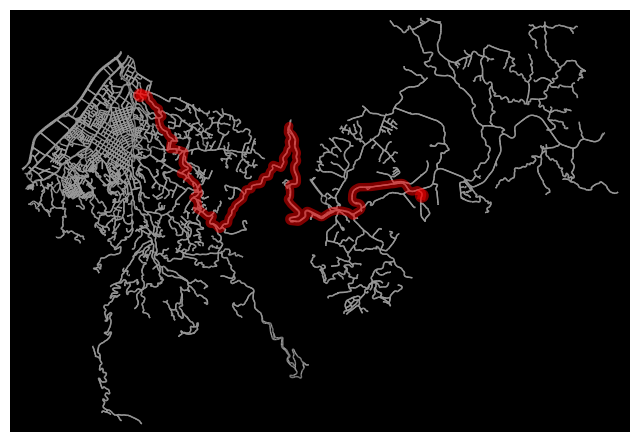

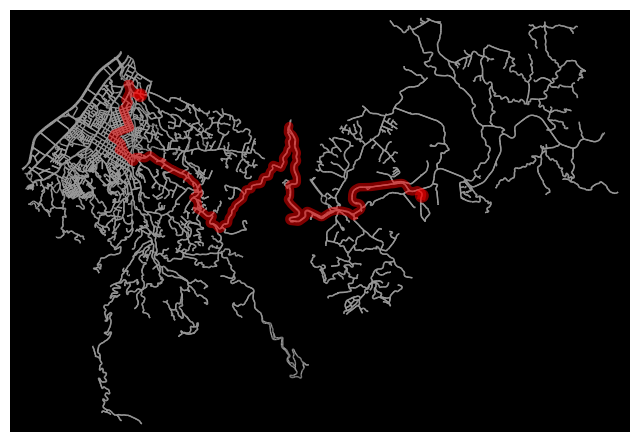

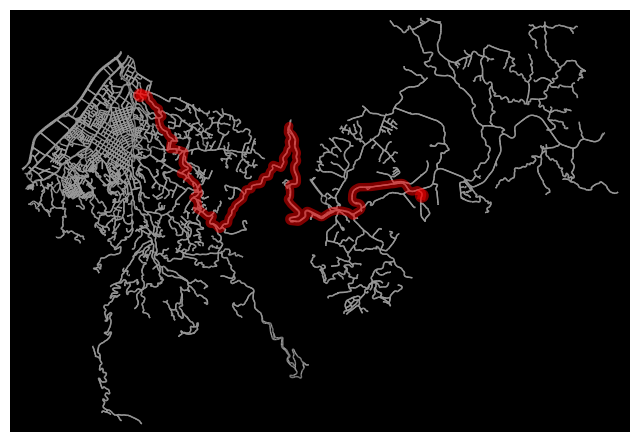

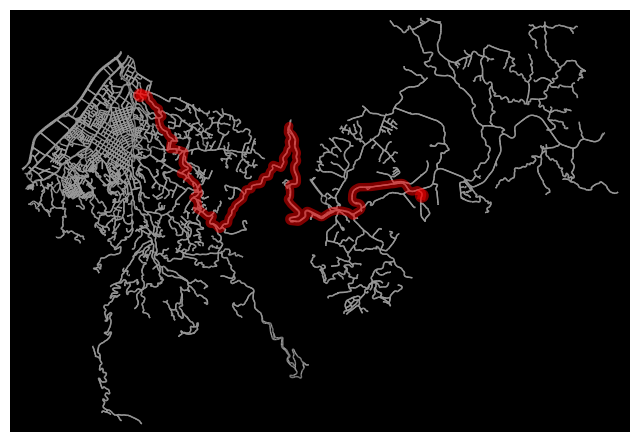

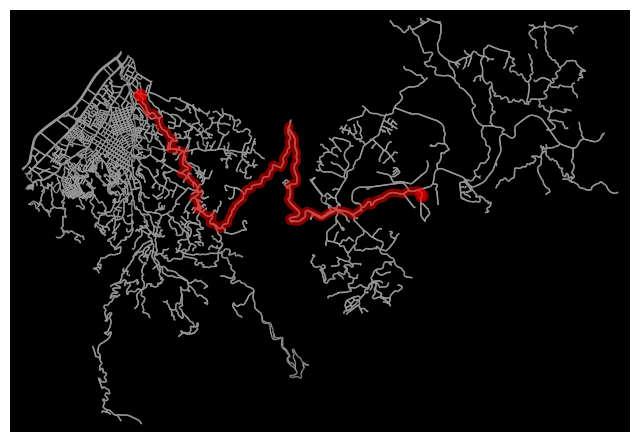

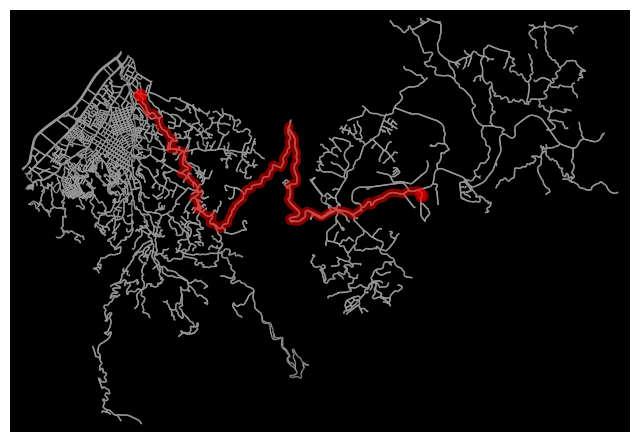

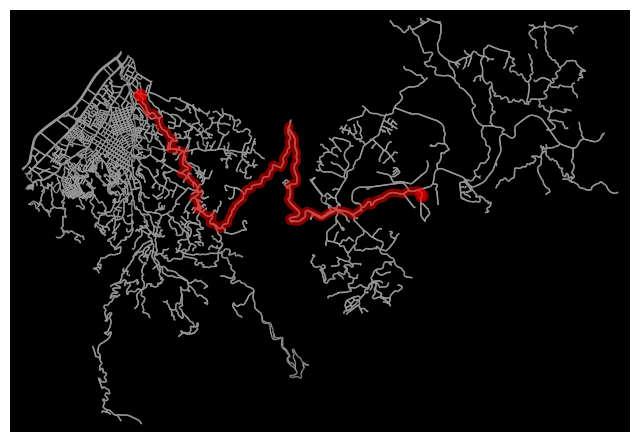

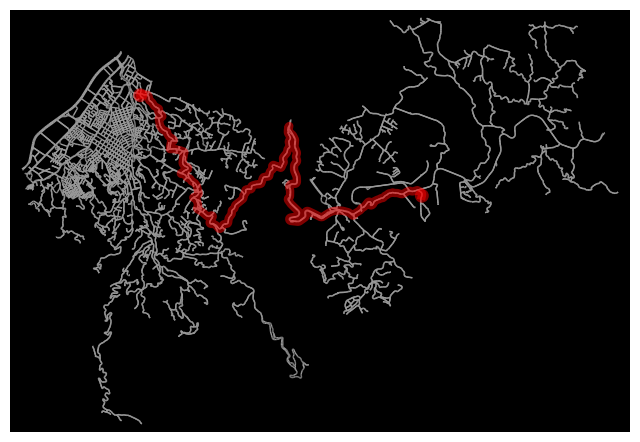

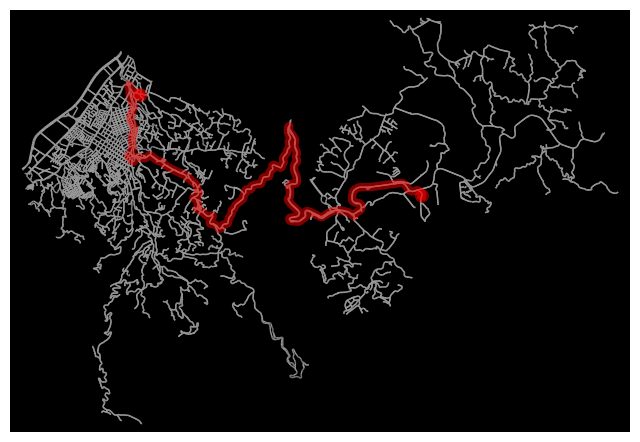

In [ ]:
#Ahora mostramos las 7 rutas en 7 figuras diferentes
fig, ax = ox.plot_graph_route(G, route_time, route_linewidth=6, node_size=0, bgcolor='k',)
fig, ax = ox.plot_graph_route(G, route_grade, route_linewidth=6, node_size=0, bgcolor='k')
fig, ax = ox.plot_graph_route(G, route_time_grade, route_linewidth=6, node_size=0, bgcolor='k')
fig, ax = ox.plot_graph_route(G, route_time_grade2, route_linewidth=6, node_size=0, bgcolor='k')
fig, ax = ox.plot_graph_route(G, route_length, route_linewidth=6, node_size=0, bgcolor='k')
fig, ax = ox.plot_graph_route(G, route_length_grade, route_linewidth=6, node_size=0, bgcolor='k')
fig, ax = ox.plot_graph_route(G, route_length_grade2, route_linewidth=6, node_size=0, bgcolor='k')
fig, ax = ox.plot_graph_route(G, route_length_time, route_linewidth=6, node_size=0, bgcolor='k')
fig, ax = ox.plot_graph_route(G, route_main_road, route_linewidth=6, node_size=0, bgcolor='k')



Podemos hacer el mismo ejemplo buscando otra ruta pero ahora por distancia (en este caso usaríamos como peso la columna *length*)

Comparar las dos rutas

In [ ]:
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'travel_time')))
print('Ruta 1 tiene', route1_length, 'metros y toma', route1_time, 'segundos.')
print('Ruta 2 tiene', route2_length, 'metros y toma', route2_time, 'segundos.')

In [ ]:
len(r)

In [ ]:
ox.plot_graph_route(G, route2, route_color='b',route_linewidth=6, node_size=0, bgcolor='k',figsize=(20, 20))

## Dataframe geográfico con información del mapa

Podemos crear nuestro propio dataframe con los datos que tenemos en el grafo

In [ ]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []

for u, v in zip(route_main_road[:-1], route_main_road[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

In [ ]:
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from,  X_to, Y_to, length, travel_time)),
               columns =["node_start", "node_end", "X_from", "Y_from",  "X_to", "Y_to", "length", "travel_time"])
df.head()

node_start    node_end     X_from    Y_from       X_to      Y_to  length  \
0  9397052814   340686744 -75.579015  6.179106 -75.579029  6.179189       9   
1   340686744   340686745 -75.579029  6.179189 -75.579025  6.179278      10   
2   340686745   340686746 -75.579025  6.179278 -75.578987  6.179407      15   
3   340686746  5532256386 -75.578987  6.179407 -75.579115  6.179400      14   
4  5532256386  4404924416 -75.579115  6.179400 -75.579207  6.179403      10   

   travel_time  
0            1  
1            1  
2            2  
3            1  
4            1

In [ ]:
df.reset_index(inplace=True)
df.head()

index  node_start    node_end     X_from    Y_from       X_to      Y_to  \
0      0  9397052814   340686744 -75.579015  6.179106 -75.579029  6.179189   
1      1   340686744   340686745 -75.579029  6.179189 -75.579025  6.179278   
2      2   340686745   340686746 -75.579025  6.179278 -75.578987  6.179407   
3      3   340686746  5532256386 -75.578987  6.179407 -75.579115  6.179400   
4      4  5532256386  4404924416 -75.579115  6.179400 -75.579207  6.179403   

   length  travel_time  
0       9            1  
1      10            1  
2      15            2  
3      14            1  
4      10            1

Crear un dataframe geográfico a partir de este para poder tneer las longitudes y latitudes comp puntos geométricos

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry('line')

In [ ]:
start = df[df["node_start"] == start_node]
end = df[df["node_end"] == end_node]

## Diferentes formas de visualización en otros mapas

Mapbox requiere access token para algunas visualizaciones como:

'basic', 'streets', 'outdoors', 'light', 'dark', 'satellite', 'satellite- streets'

Sin embargo hay otros mapbox_style que no requieren access token como:

'open-street-map', 'white-bg', 'carto-positron', 'carto-darkmatter', 'stamen- terrain', 'stamen-toner', 'stamen-watercolor'

In [ ]:
def display_interactive_route(route):
  node_start = []
  node_end = []
  X_to = []
  Y_to = []
  X_from = []
  Y_from = []
  length = []
  travel_time = []
  
  for u, v in zip(route[:-1], route[1:]):
      node_start.append(u)
      node_end.append(v)
      length.append(round(G.edges[(u, v, 0)]['length']))
      travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
      X_from.append(G.nodes[u]['x'])
      Y_from.append(G.nodes[u]['y'])
      X_to.append(G.nodes[v]['x'])
      Y_to.append(G.nodes[v]['y'])
  df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from,  X_to, Y_to, length, travel_time)),
               columns =["node_start", "node_end", "X_from", "Y_from",  "X_to", "Y_to", "length", "travel_time"])
  df.reset_index(inplace=True)
  gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
  gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
  gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
  line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry('line')
  start = df[df["node_start"] == start_node]
  end = df[df["node_end"] == end_node]
  fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=12, width=1000, height=600, animation_frame="index",mapbox_style='open-street-map')
  fig.data[0].marker = dict(size = 12, color="black")
  fig.add_trace(px.scatter_mapbox(start, lon= "X_from", lat="Y_from").data[0])
  fig.data[1].marker = dict(size = 15, color="red")
  fig.add_trace(px.scatter_mapbox(end, lon= "X_from", lat="Y_from").data[0])
  fig.data[2].marker = dict(size = 15, color="green")
  fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])
  return fig
  
  
  

In [ ]:
fig = display_interactive_route(route_length)
fig